In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import Bio.PDB.Polypeptide as pp
from os.path import join
from sklearn.metrics import auc
import os
from main_functions import *

In [2]:
DATA = 'data/'

In [3]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
get_name = dict(zip(proteins, protein_names))

In [4]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']

In [5]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

In [6]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

### ROC curve

$$ \text{True Positive Rate} = \frac{\text{TP}}{\text{TP + FN}} $$ \
$$ \text{False Positive Rate} = \frac{\text{FP}}{\text{FP + TN}} $$

In [7]:
def DataCutoffROC(functional_percentage, network_mincount, thresh=9.0):
    """Return DataFrame with data to plot ROC curve. For each protein, we calculate true positive rate and
    false positive rate, then obtain the mean. Vary cutoff from 1 to 2. Tests predictions for sensitivity."""
    cutoffs = [round(x,2) for x in np.linspace(0,3,101)][1:]
    
    proteins2 = proteins + ["Mean"]
    index = pd.MultiIndex.from_product([proteins2, ["TPR", "FPR"]], names=["Protein", "Measure"])
    df = pd.DataFrame(index=index, columns=cutoffs)
    
    for protein in proteins:
        funct_extremes = GetPercentage(functional_percentage, 'lowest', functional_data[protein])
        total_positions = set(functional_data[protein].columns)
        for cutoff in cutoffs:
            measure_cutoffs = [cutoff]*3
            network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs=measure_cutoffs, 
                                                  thresh=thresh)
            if cutoff == 0:
                print(protein, len())
            TP = len(network_extremes.intersection(funct_extremes))
            FP = len(network_extremes.difference(funct_extremes))
            FN = len(funct_extremes.difference(network_extremes))
            TN = len(total_positions) - TP - FP - FN
            
            df.at[(protein, "TPR"), cutoff] = round(TP/(TP+FN), 3)
            df.at[(protein, "FPR"), cutoff] = round(FP/(FP+TN), 3)
            
    df.loc[("Mean", "TPR")] = df[df.index.get_level_values('Measure').isin(['TPR'])].mean()
    df.loc[("Mean", "FPR")] = df[df.index.get_level_values('Measure').isin(['FPR'])].mean()
    
    return df

In [8]:
def DataCutoffROC_R(functional_percentage, network_mincount, thresh=9.0):
    """Return DataFrame with data to plot ROC curve. For each protein, we calculate true positive rate and
    false positive rate, then obtain the mean. Vary cutoff from 1 to 2. Tests predictions for robustness. """
    cutoffs = [round(x,2) for x in np.linspace(0,3,101)][1:]
    
    proteins2 = proteins + ["Mean"]
    index = pd.MultiIndex.from_product([proteins2, ["TPR", "FPR"]], names=["Protein", "Measure"])
    df = pd.DataFrame(index=index, columns=cutoffs)
    
    for protein in proteins:
        funct_extremes = GetPercentage(functional_percentage, 'highest', functional_data[protein])
        total_positions = set(functional_data[protein].columns)
        
        for cutoff in cutoffs:
            measure_cutoffs = [cutoff]*3
            network_extremes_loss = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
            network_extremes = set([pos for pos in total_positions if pos not in network_extremes_loss])
        
            if cutoff == 0:
                print(protein, len())
            TP = len(network_extremes.intersection(funct_extremes))
            FP = len(network_extremes.difference(funct_extremes))
            FN = len(funct_extremes.difference(network_extremes))
            TN = len(total_positions) - TP - FP - FN
            
            df.at[(protein, "TPR"), cutoff] = round(TP/(TP+FN), 3)
            df.at[(protein, "FPR"), cutoff] = round(FP/(FP+TN), 3)
            
    df.loc[("Mean", "TPR")] = df[df.index.get_level_values('Measure').isin(['TPR'])].mean()
    df.loc[("Mean", "FPR")] = df[df.index.get_level_values('Measure').isin(['FPR'])].mean()
    
    return df

In [23]:
def ROC_R(df):
    """Plot ROC from DataFrame (obtained from DataCutoffROC), calculate AUC. Data from robustness predictions. """
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharex=True, sharey=True)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('True Positive Rate', labelpad=8)
    plt.xlabel('False Positive Rate', labelpad=6)
    
    #colors = ['C0', 'C2', 'C4', 'C6', 'C9', '#9D2EC5']
    #colors = ['#DB4939', '#F48B28', '#EDE172', '#A1D755', '#4B8B63', '#1FB689']
    colors = ['#7fc97f', '#beaed4', '#fdc086', '#f08080', '#386cb0', '#f0027f']
    areas = []
    proteins2 = proteins + ["Mean"]
    for i, protein in enumerate(proteins2):
        tpr = df.loc[(protein, "TPR"), :].values.tolist()
        fpr = df.loc[(protein, "FPR"), :].values.tolist()
        
        ax = plt.gca()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        
        areas.append(auc([0]+fpr+[1],[0]+tpr+[1])) ## add AUC
        if protein!="Mean":
            label = f"{protein_names[i]} (AUC = {areas[i]:.2f})"
        else:
            label = f"Mean (AUC = {np.mean(areas):.2f} $\pm$ {np.std(areas):.2f})"
        
        linewidth = 0.8 if i!=5 else 2
        ax.plot(fpr, tpr, markeredgewidth=0.0, linewidth=linewidth, color=colors[i], 
                label=label)
        ax.plot([0, fpr[0]], [0, tpr[0]], '--', markeredgewidth=0.0, linewidth=1, color=colors[i])
        ax.plot([fpr[-1], 1], [tpr[-1], 1], '--', markeredgewidth=0.0, linewidth=1, color=colors[i])
        
        ax.set_aspect(1./ax.get_data_ratio())
        
    ax.plot([0,1], [0,1], "--", markeredgewidth=0.0, linewidth=1, color='C7')    
    handles, labels = ax.get_legend_handles_labels()       
    fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.91, 0.12), frameon=False)
        
    return fig

In [21]:
def ROC(df):
    """Plot ROC from DataFrame (obtained from DataCutoffROC), calculate AUC."""
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharex=True, sharey=True)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('True Positive Rate', labelpad=8)
    plt.xlabel('False Positive Rate', labelpad=6)
    
    colors = ['#7fc97f', '#beaed4', '#fdc086', '#f08080', '#386cb0', '#f0027f']
    
    areas = []
    proteins2 = proteins + ["Mean"]
    for i, protein in enumerate(proteins2):
        tpr = df.loc[(protein, "TPR"), :].values.tolist()
        fpr = df.loc[(protein, "FPR"), :].values.tolist()
        
        ax = plt.gca()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        
        areas.append(auc([1]+fpr+[0],[1]+tpr+[0])) ## add AUC
        if protein!="Mean":
            label = f"{protein_names[i]} (AUC = {areas[i]:.2f})"
        else:
            label = f"Mean (AUC = {np.mean(areas):.2f} $\pm$ {np.std(areas):.2f})"
        
        linewidth = 0.8 if i!=5 else 2
        ax.plot(fpr, tpr, markeredgewidth=0.0, linewidth=linewidth, color=colors[i], 
                label=label)
        ax.plot([1, fpr[0]], [1, tpr[0]], '--', markeredgewidth=0.0, linewidth=1, color=colors[i])
        ax.plot([fpr[-1], 0], [tpr[-1], 0], '--', markeredgewidth=0.0, linewidth=1, color=colors[i])
        
        ax.set_aspect(1./ax.get_data_ratio())
        
    ax.plot([0,1], [0,1], "--", markeredgewidth=0.0, linewidth=1, color='C7')    
    handles, labels = ax.get_legend_handles_labels()       
    fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.91, 0.12), frameon=False)
        
    return fig

In [13]:
df = DataCutoffROC(0.4, 2)

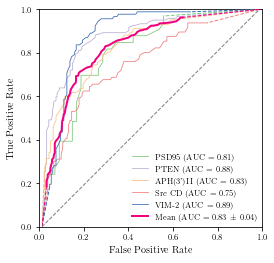

In [22]:
roc_cutoffs = ROC(df)
roc_cutoffs.savefig("figures/roc_cutoffs_2_no_dist.png", dpi=300)

In [129]:
#### ROC curves for robustness predictions

In [25]:
df_cutoffs_1_r = DataCutoffROC_R(0.4,1)

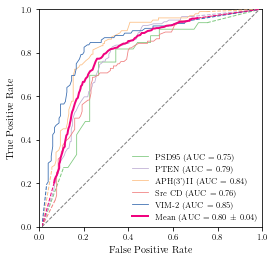

In [26]:
roc_cutoffs_1_r = ROC_R(df_cutoffs_1_r)
roc_cutoffs_1_r.savefig("figures/roc_cutoffs_1_gain_no_dist.png", dpi=300)